# CAOS (Continuous Angle Orientation System)
##### Davide Brinati, Davide Meloni, Alberto Raimondi

Codice per il progetto di Advanced Machine Learning

In [1]:
import sys
sys.path.append('/usr/local/lib/python3.5/dist-packages/')

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import math
import matplotlib.pyplot as plt
import cv2
import random
import os, sys
import time
import copy
import xml.etree.ElementTree as ET
from xml.etree import cElementTree as ET
from bs4 import BeautifulSoup
import imutils
from skimage import io, transform
from sklearn.datasets import fetch_mldata
import multiprocessing

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.utils.data.dataset import Dataset # For custom datasets
import torchvision
from torchvision import datasets, transforms,models 

%load_ext autoreload
%autoreload 2

Rotation Function

In [3]:
def rotated_rect(w, h, angle):
    """
    Given a rectangle of size wxh that has been rotated by 'angle' (in
    radians), computes the width and height of the largest possible
    axis-aligned rectangle within the rotated rectangle.

    Original JS code by 'Andri' and Magnus Hoff from Stack Overflow

    Converted to Python by Aaron Snoswell
    """
    angle = math.radians(angle)
    quadrant = int(math.floor(angle / (math.pi / 2))) & 3
    sign_alpha = angle if ((quadrant & 1) == 0) else math.pi - angle
    alpha = (sign_alpha % math.pi + math.pi) % math.pi

    bb_w = w * math.cos(alpha) + h * math.sin(alpha)
    bb_h = w * math.sin(alpha) + h * math.cos(alpha)

    gamma = math.atan2(bb_w, bb_w) if (w < h) else math.atan2(bb_w, bb_w)

    delta = math.pi - alpha - gamma

    length = h if (w < h) else w

    d = length * math.cos(alpha)
    a = d * math.sin(alpha) / math.sin(delta)

    y = a * math.cos(gamma)
    x = y * math.tan(gamma)

    return (bb_w - 2 * x, bb_h - 2 * y)

def crop(img, w, h):
    x, y = int(img.shape[1] * .5), int(img.shape[0] * .5)

    return img[
        int(np.ceil(y - h * .5)) : int(np.floor(y + h * .5)),
        int(np.ceil(x - w * .5)) : int(np.floor(x + h * .5))
    ]

def rotate(img, angle, output_shape):
    # rotate, crop and return original size
#     print(img.shape)
    # rotate, crop and return original size
    (h, w) = img.shape[:2]
    img = imutils.rotate_bound(img, angle)
    img = crop(img, *rotated_rect(w, h, angle))
    img = cv2.resize(img,(output_shape,output_shape),interpolation=cv2.INTER_AREA)
    return img

In [4]:
class Processor:
    def __init__(self,threshold):
        self._threshold=threshold

    def __call__(self,filename):
        img = io.imread(filename)
        return img

In [5]:
class face_dataset(Dataset):
    def __init__(self,root_dir, mode='Train/', transform=None, copy=False, length=-1):
        
        self.root_dir = root_dir                                #directory fino a .../UTKFace/advanced_ml
        self.mode = mode
        self.root_dir_deep = root_dir + '/' + self.mode              #qua ho .../UTKFace/advanced_ml/training o test
        self.files = os.listdir(self.root_dir_deep)[:length]

#         if mode == 'train':
#             self.ds = (X_train,y_train)
#         elif mode == 'test':
#             self.ds = (X_test,y_test)
        if copy:
            self.images=copy.dataset.images
        else:
            proc = Processor(128)
            pool=multiprocessing.Pool()
            self.images = pool.map(
                proc,
                [self.root_dir_deep+file for file in self.files]
            )
            self.images = np.array([img for img in self.images if type(img)!=str])

            
#         self.rotations = [0.,90.,180.,270.]
#         self.mode = mode
        self.transform = transform
#         self.rotations = [0.,90.,180.,-90.]

    def __len__(self):
        
        return len(self.images)

    def preprocess(self, image):
        if self.mode == 'Train/':
            if np.random.random()<0.5:
                image = np.flip(image, axis=1)
        
        rot = np.random.random() * 360. - 180.
        image = np.array(rotate(image, rot, 64))
        
        return image, rot*math.pi/180.
    
    def one_ch_to_three(self, image):        #Force image to be RGB
        gray = cv2.cvtColor(image[:,:,np.newaxis], cv2.COLOR_BGR2GRAY)
        img = np.zeros_like(image)
        img[:,:,0] = gray
        img[:,:,1] = gray
        img[:,:,2] = gray
        
        return img

    def __getitem__(self, idx):
        
        img = self.images[idx]
        if len(img.shape) < 3:
            print(self.files[idx])
            img = self.one_ch_to_three(img)                   
        image, angle = self.preprocess(img[:,:,:3])

        sample = {'image': image, "angle": angle}

        if self.transform:
            image_t = self.transform(sample["image"])
            sample = {'image': image_t, "angle": angle}


        return sample


In [8]:
train_transf = transforms.Compose([transforms.ToPILImage(),
#                              transforms.RandomApply([transforms.RandomCrop(64)], p=0.33),
                             transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.05),
                             transforms.Resize(64),
                             transforms.ToTensor(),
                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

valid_transf = transforms.Compose([transforms.ToPILImage(),
                             transforms.Resize(64),
                             transforms.ToTensor(),
                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

### Instance Train loder

In [29]:
train_loader = torch.utils.data.DataLoader(face_dataset(root_dir = 'VGGFace/',
                                                        mode='Train/',
                                                        transform=train_transf,
                                                        #copy=train_loader
                                                       ), 
                                                        batch_size=128, shuffle=True)

In [9]:
train_loader_few = torch.utils.data.DataLoader(face_dataset(root_dir = 'VGGFace/',
                                                        mode='Train/',
                                                        transform=train_transf,
#                                                         copy=train_loader,
                                                        length=1028
                                                       ), 
                                                        batch_size=128, shuffle=True)

In [96]:
len(train_loader)

162

In [12]:
len(valid_loader.dataset.images)

2999

163 batches of 128 items

### Instance validation loader

In [10]:
valid_loader = torch.utils.data.DataLoader(face_dataset(root_dir = 'VGGFace/',
                                                        mode='Test/',
                                                        transform=valid_transf), 
                                                         batch_size=128, shuffle=True)

In [13]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

### Model

In [46]:
locnet=models.squeezenet1_1(pretrained=True)
locnet.classifier[0]=nn.Dropout(p=0.4)
locnet.classifier[1]=nn.Conv2d(512,2,kernel_size=(1, 1), stride=(1, 1))

locnet.classifier[2]= nn.Dropout(0)
locnet.classifier[3]=nn.AdaptiveAvgPool2d(output_size=1)

locnet.num_classes=2

In [47]:
model_locnet = locnet.cuda()

In [48]:
summary(model_locnet, (3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 31, 31]           1,792
              ReLU-2           [-1, 64, 31, 31]               0
         MaxPool2d-3           [-1, 64, 15, 15]               0
            Conv2d-4           [-1, 16, 15, 15]           1,040
              ReLU-5           [-1, 16, 15, 15]               0
            Conv2d-6           [-1, 64, 15, 15]           1,088
              ReLU-7           [-1, 64, 15, 15]               0
            Conv2d-8           [-1, 64, 15, 15]           9,280
              ReLU-9           [-1, 64, 15, 15]               0
             Fire-10          [-1, 128, 15, 15]               0
           Conv2d-11           [-1, 16, 15, 15]           2,064
             ReLU-12           [-1, 16, 15, 15]               0
           Conv2d-13           [-1, 64, 15, 15]           1,088
             ReLU-14           [-1, 64,

In [12]:
# locnet.load_state_dict(torch.load('resnet_weights.pt', map_location='cpu'))

In [14]:
locnet = locnet.cpu()

In [17]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):

        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub(m).div(s)
        return tensor
    
unorm = UnNormalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
tr2=transforms.ToPILImage()

def magic(t):
    t_c = torch.Tensor(t)
    t_c=unorm(t_c)
    t_c=tr2(t_c)
    return t_c

In [ ]:
# corda = torch.sin(theta/2.0)
# Loss needs to be written

In [49]:
def rope_loss(output, target):
    
    alpha = torch.sub(output.float(), target.float())   #Meloni Theorem
#     temp = torch.div(alpha, 2)
#     temp = torch.sin(temp)
    cos_diss = (1-torch.cos(alpha))/2
    
    return cos_diss

In [62]:
criterion = rope_loss
optimizer = optim.Adam(model_locnet.parameters(), lr=1e-5)

In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Training function

In [60]:
def train_model(model, num_epochs=5, scheduler=None):
    since = time.time()
       
    history = {}
    history['training'] = []
    history['validation'] = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-' * 10)

        # Each epoch has a training and a validation phase so..
        phases = ['training']
        if epoch%10==0:
            phases = ['training', 'validation']
        for phase in phases:
            if phase == 'training':
                if scheduler is not None:
                    scheduler.step()
                model.train()
                lossa = []
                delta_m = []
                for batch_idx, dizio in enumerate(train_loader):
                    data,target=dizio["image"], dizio["angle"]
                    data = data.to(device, dtype=torch.float)
                    target = target.to(device, dtype=torch.float)

                    optimizer.zero_grad()

                    prev = model(data)        
                    output =  torch.atan2(prev[:,0], prev[:,1]) #F.tanh(prev)* math.pi

                    loss = criterion(output, target)

                    loss.backward(torch.ones(loss.shape[0]).cuda())#
                    optimizer.step()
                    theta_p = np.array([ang for ang in output.cpu().detach().numpy()])
                    theta_t = np.array([ang for ang in target.cpu().detach().numpy()])
                    delta_m.append((1-np.mean(np.cos(np.subtract(theta_p,theta_t))))/2)

                    lossa.append(loss.mean().item())
                    
                    if batch_idx != 0 and batch_idx % 50 == 0:
                        print('Training Iteration: {}\tLoss: {:.4f}'.format(batch_idx, np.mean(lossa)))
                    
                print('{} Loss: {:.4f} | Dtheta: {:.4f}'.format(phase, np.mean(lossa), np.mean(delta_m)))
                history['training'].append(np.mean(lossa))
            else:
                model.eval()
                lossa = []
                delta_m = []
                for batch_idx, dizio in enumerate(valid_loader):
                    data, target = dizio["image"], dizio["angle"]
                    data = data.to(device, dtype=torch.float)
                    target = target.to(device, dtype=torch.float)

                    prev = model(data)        
                    output = torch.atan2(prev[:,0], prev[:,1]) # F.tanh(prev) * math.pi
                    
                    loss = criterion(output, target)
                    theta_p = np.array([ang for ang in output.cpu().detach().numpy()])
                    theta_t = np.array([ang for ang in target.cpu().detach().numpy()])
                    delta_m.append((1-np.mean(np.cos(np.subtract(theta_p,theta_t))))/2)
                    
                    lossa.append(loss.mean().item())
                
                epoch_loss = np.mean(lossa)
                print('{} Loss: {:.4f} | Dtheta: {:.4f}'.format(phase, epoch_loss, np.mean(delta_m)))
                history['validation'].append(epoch_loss)
                torch.save(model.state_dict(), 'squizzo_weights.pt')
                
                if epoch%10==0.:
                    dizio = next(iter(valid_loader))
                    img, angle = dizio['image'][0], dizio['angle'][0]
                    ciao = magic(img.cpu())

                    plt.imshow(ciao);plt.show()


                    c = img.reshape(1,3,64,64)

                    # c = torch.tensor(c, dtype=torch.float)
                    # c = transf(c)        #To tensor e normalizing images
                    c = c.to(device)
                    out = model(c)
                    res = torch.atan2(out[:,0], out[:,1]) #F.tanh(out)  * math.pi
                    res = res.cpu().detach().numpy()[0]#[0,0]
                    res=res*180./math.pi
                    gt_angle = (angle*180/math.pi).cpu().detach().numpy()
                    plt.imshow(imutils.rotate(np.array(ciao), res)); plt.show()
                    print('Target Angle: {:.3f} | Predicted Angle: {:.3f}'.format(gt_angle,res))

    time_elapsed = time.time() - since
    print('Training completed in {:.0f}min and {:.0f}sec'.format(time_elapsed // 60,
                                                                 time_elapsed % 60))

    return model, history          

In [53]:
# model_locnet.load_state_dict(torch.load('final_weights.pt'))

Epoch 0/10
----------
training Loss: 0.1513 | Dtheta: 0.1513
validation Loss: 0.1544 | Dtheta: 0.1544


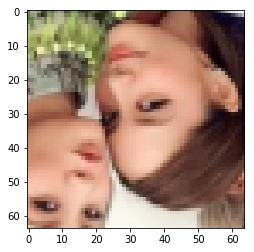

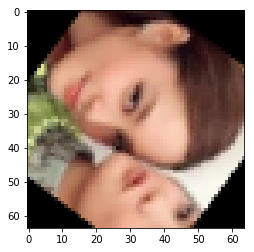

Target Angle: -167.200 | Predicted Angle: 53.148
Epoch 1/10
----------
training Loss: 0.1466 | Dtheta: 0.1466
Epoch 2/10
----------
training Loss: 0.1637 | Dtheta: 0.1637
Epoch 3/10
----------
training Loss: 0.1335 | Dtheta: 0.1335
Epoch 4/10
----------
training Loss: 0.1149 | Dtheta: 0.1149
Epoch 5/10
----------
training Loss: 0.1321 | Dtheta: 0.1321
Epoch 6/10
----------
training Loss: 0.1331 | Dtheta: 0.1331
Epoch 7/10
----------
training Loss: 0.1667 | Dtheta: 0.1667
Epoch 8/10
----------
training Loss: 0.1127 | Dtheta: 0.1127
Epoch 9/10
----------
training Loss: 0.0980 | Dtheta: 0.0980
Epoch 10/10
----------
training Loss: 0.1086 | Dtheta: 0.1086
validation Loss: 0.1211 | Dtheta: 0.1211


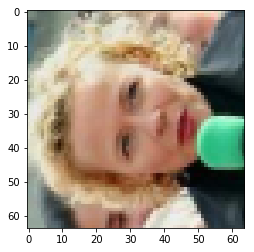

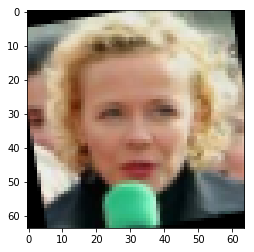

Target Angle: -82.054 | Predicted Angle: -80.206
Training completed in 1min and 14sec


In [55]:
model_fitted, loss_history = train_model(model_locnet, num_epochs=11, scheduler=None)

Epoch 0/10
----------
Training Iteration: 50	Loss: 0.1352
Training Iteration: 100	Loss: 0.1293
Training Iteration: 150	Loss: 0.1209
Training Iteration: 200	Loss: 0.1155
training Loss: 0.1138 | Dtheta: 0.1138
validation Loss: 0.0865 | Dtheta: 0.0865


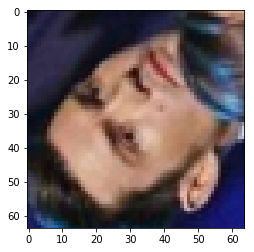

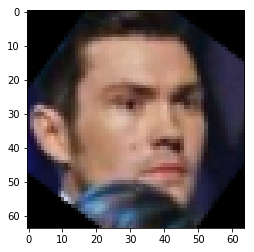

Target Angle: -134.334 | Predicted Angle: -126.637
Epoch 1/10
----------
Training Iteration: 50	Loss: 0.1472
Training Iteration: 100	Loss: 0.1401
Training Iteration: 150	Loss: 0.1283
Training Iteration: 200	Loss: 0.1221
training Loss: 0.1190 | Dtheta: 0.1190
Epoch 2/10
----------
Training Iteration: 50	Loss: 0.0950
Training Iteration: 100	Loss: 0.0925
Training Iteration: 150	Loss: 0.0974
Training Iteration: 200	Loss: 0.1002
training Loss: 0.0988 | Dtheta: 0.0988
Epoch 3/10
----------
Training Iteration: 50	Loss: 0.0912
Training Iteration: 100	Loss: 0.0877
Training Iteration: 150	Loss: 0.0863
Training Iteration: 200	Loss: 0.0876
training Loss: 0.0858 | Dtheta: 0.0858
Epoch 4/10
----------
Training Iteration: 50	Loss: 0.0731
Training Iteration: 100	Loss: 0.1004
Training Iteration: 150	Loss: 0.1026
Training Iteration: 200	Loss: 0.0994
training Loss: 0.0975 | Dtheta: 0.0975
Epoch 5/10
----------
Training Iteration: 50	Loss: 0.0773
Training Iteration: 100	Loss: 0.0850
Training Iteration: 15

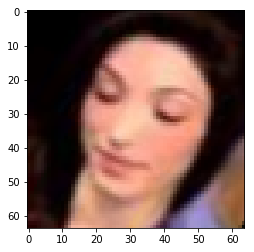

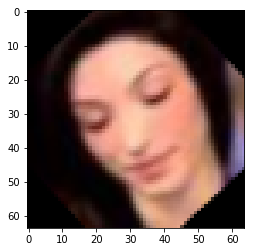

Target Angle: 30.196 | Predicted Angle: 42.771
Training completed in 34min and 30sec


In [57]:
model_fitted, loss_history1 = train_model(model_locnet, num_epochs=11, scheduler=None)

Epoch 0/19
----------
Training Iteration: 50	Loss: 0.0576
Training Iteration: 100	Loss: 0.0551
Training Iteration: 150	Loss: 0.0534
Training Iteration: 200	Loss: 0.0533
training Loss: 0.0519 | Dtheta: 0.0519
validation Loss: 0.0413 | Dtheta: 0.0413


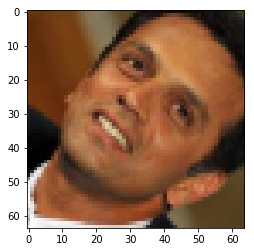

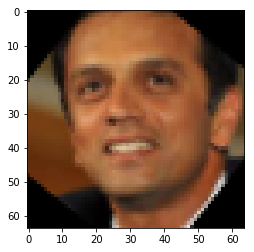

Target Angle: 58.982 | Predicted Angle: 51.470
Epoch 1/19
----------
Training Iteration: 50	Loss: 0.0510
Training Iteration: 100	Loss: 0.0488
Training Iteration: 150	Loss: 0.0487
Training Iteration: 200	Loss: 0.0482
training Loss: 0.0481 | Dtheta: 0.0481
Epoch 2/19
----------
Training Iteration: 50	Loss: 0.0498
Training Iteration: 100	Loss: 0.0483
Training Iteration: 150	Loss: 0.0488
Training Iteration: 200	Loss: 0.0477
training Loss: 0.0472 | Dtheta: 0.0472
Epoch 3/19
----------
Training Iteration: 50	Loss: 0.0464
Training Iteration: 100	Loss: 0.0458
Training Iteration: 150	Loss: 0.0461
Training Iteration: 200	Loss: 0.0461
training Loss: 0.0465 | Dtheta: 0.0465
Epoch 4/19
----------
Training Iteration: 50	Loss: 0.0434
Training Iteration: 100	Loss: 0.0451
Training Iteration: 150	Loss: 0.0459
Training Iteration: 200	Loss: 0.0450
training Loss: 0.0450 | Dtheta: 0.0450
Epoch 5/19
----------
Training Iteration: 50	Loss: 0.0478
Training Iteration: 100	Loss: 0.0465
Training Iteration: 150	Lo

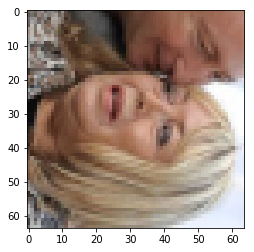

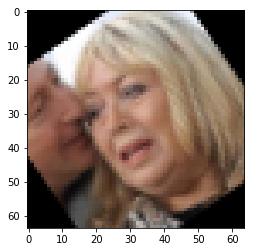

Target Angle: 100.515 | Predicted Angle: 124.665
Epoch 11/19
----------
Training Iteration: 50	Loss: 0.0423
Training Iteration: 100	Loss: 0.0413
Training Iteration: 150	Loss: 0.0417
Training Iteration: 200	Loss: 0.0422
training Loss: 0.0416 | Dtheta: 0.0416
Epoch 12/19
----------
Training Iteration: 50	Loss: 0.0411
Training Iteration: 100	Loss: 0.0418
Training Iteration: 150	Loss: 0.0421
Training Iteration: 200	Loss: 0.0424
training Loss: 0.0422 | Dtheta: 0.0422
Epoch 13/19
----------
Training Iteration: 50	Loss: 0.0408
Training Iteration: 100	Loss: 0.0383
Training Iteration: 150	Loss: 0.0398
Training Iteration: 200	Loss: 0.0398
training Loss: 0.0398 | Dtheta: 0.0398
Epoch 14/19
----------
Training Iteration: 50	Loss: 0.0404
Training Iteration: 100	Loss: 0.0400
Training Iteration: 150	Loss: 0.0405
Training Iteration: 200	Loss: 0.0400
training Loss: 0.0398 | Dtheta: 0.0398
Epoch 15/19
----------
Training Iteration: 50	Loss: 0.0386
Training Iteration: 100	Loss: 0.0403
Training Iteration:

In [59]:
model_fitted, loss_history2 = train_model(model_locnet, num_epochs=20, scheduler=None)

Epoch 0/10
----------
Training Iteration: 50	Loss: 0.0391
Training Iteration: 100	Loss: 0.0389
Training Iteration: 150	Loss: 0.0389
Training Iteration: 200	Loss: 0.0395
training Loss: 0.0394 | Dtheta: 0.0394
validation Loss: 0.0341 | Dtheta: 0.0341


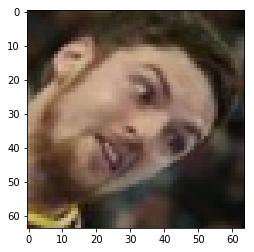

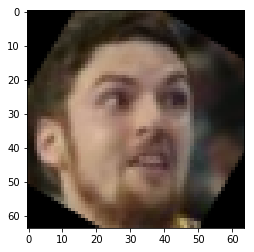

Target Angle: 30.815 | Predicted Angle: 58.845
Epoch 1/10
----------
Training Iteration: 50	Loss: 0.0387
Training Iteration: 100	Loss: 0.0386
Training Iteration: 150	Loss: 0.0386
Training Iteration: 200	Loss: 0.0384
training Loss: 0.0382 | Dtheta: 0.0382
Epoch 2/10
----------
Training Iteration: 50	Loss: 0.0371
Training Iteration: 100	Loss: 0.0383
Training Iteration: 150	Loss: 0.0385
Training Iteration: 200	Loss: 0.0386
training Loss: 0.0382 | Dtheta: 0.0382
Epoch 3/10
----------
Training Iteration: 50	Loss: 0.0408
Training Iteration: 100	Loss: 0.0381
Training Iteration: 150	Loss: 0.0375
Training Iteration: 200	Loss: 0.0379
training Loss: 0.0386 | Dtheta: 0.0386
Epoch 4/10
----------
Training Iteration: 50	Loss: 0.0417
Training Iteration: 100	Loss: 0.0396
Training Iteration: 150	Loss: 0.0385
Training Iteration: 200	Loss: 0.0375
training Loss: 0.0372 | Dtheta: 0.0372
Epoch 5/10
----------
Training Iteration: 50	Loss: 0.0404
Training Iteration: 100	Loss: 0.0396
Training Iteration: 150	Lo

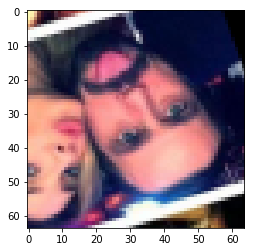

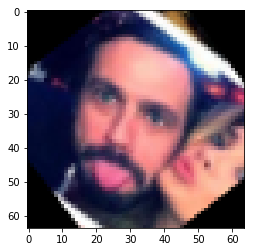

Target Angle: 161.635 | Predicted Angle: 127.661
Training completed in 34min and 13sec


In [61]:
model_fitted, loss_history3 = train_model(model_locnet, num_epochs=11, scheduler=None)

Epoch 0/10
----------
Training Iteration: 50	Loss: 0.0380
Training Iteration: 100	Loss: 0.0379
Training Iteration: 150	Loss: 0.0379
Training Iteration: 200	Loss: 0.0376
training Loss: 0.0375 | Dtheta: 0.0375
validation Loss: 0.0337 | Dtheta: 0.0337


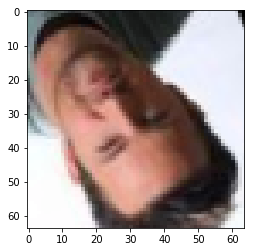

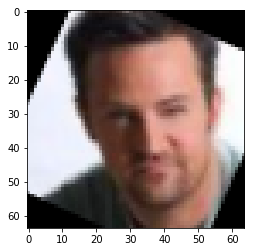

Target Angle: 159.479 | Predicted Angle: 155.640
Epoch 1/10
----------
Training Iteration: 50	Loss: 0.0359
Training Iteration: 100	Loss: 0.0368
Training Iteration: 150	Loss: 0.0371
Training Iteration: 200	Loss: 0.0367
training Loss: 0.0372 | Dtheta: 0.0372
Epoch 2/10
----------
Training Iteration: 50	Loss: 0.0369
Training Iteration: 100	Loss: 0.0369
Training Iteration: 150	Loss: 0.0369
Training Iteration: 200	Loss: 0.0368
training Loss: 0.0374 | Dtheta: 0.0374
Epoch 3/10
----------
Training Iteration: 50	Loss: 0.0344
Training Iteration: 100	Loss: 0.0364
Training Iteration: 150	Loss: 0.0358
Training Iteration: 200	Loss: 0.0364
training Loss: 0.0367 | Dtheta: 0.0367
Epoch 4/10
----------
Training Iteration: 50	Loss: 0.0365
Training Iteration: 100	Loss: 0.0355
Training Iteration: 150	Loss: 0.0356
Training Iteration: 200	Loss: 0.0360
training Loss: 0.0361 | Dtheta: 0.0361
Epoch 5/10
----------
Training Iteration: 50	Loss: 0.0375
Training Iteration: 100	Loss: 0.0367
Training Iteration: 150	

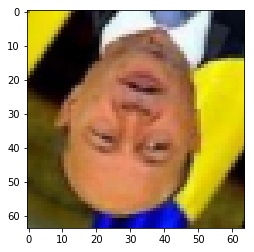

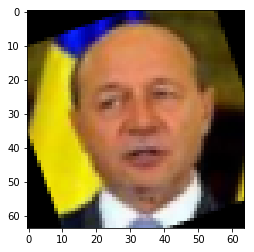

Target Angle: -155.203 | Predicted Angle: -159.976
Training completed in 34min and 28sec


In [63]:
model_fitted, loss_history4 = train_model(model_locnet, num_epochs=11, scheduler=None)

In [66]:
# model_fitted, loss_history3 = train_model(model_locnet, num_epochs=1, scheduler=None)

In [65]:
# locnet(torch.tensor(np.random.random(size=(32,3,64,64)), dtype=torch.float32).cuda()*10)

In [44]:
# model_fitted, loss_history1 = train_model(model_locnet, num_epochs=200, scheduler=None)

In [77]:
#exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)

In [33]:
x = np.random.random(size=5)
x[0:-0]

array([], dtype=float64)

### Saving model for inference

In [ ]:
model_locnet.state_dict()

In [161]:
torch.save(model_locnet.state_dict(), 'final_weights_aug.pt')

-----------------------

### Loading model for inference

In [25]:
model_locnet.load_state_dict(torch.load('C:/Users/done-/Desktop/adv_ml/angolocontinuo_weights.pth'))
model_locnet.eval()

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0

In [26]:
# tr = transforms.ToPILImage()

In [26]:
def magic(t):
    t=unorm(t)
    t=tr2(t)
    return t

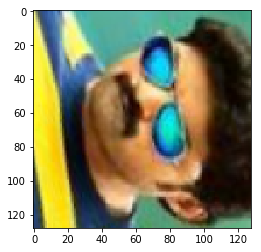

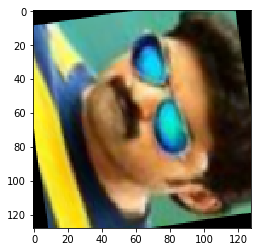

73.16397849115016 368.80303808535217


In [77]:
n=np.random.randint(0,64)
a= iter(train_loader)
b=next(a)
img, angle = b["image"][n], b["angle"][n]
# ciao = img.reshape(128,128,3)
ciao = magic(img)

plt.imshow(ciao);plt.show()


c = img.reshape(1,3,128,128)

# c = torch.tensor(c, dtype=torch.float)
# c = transf(c)        #To tensor e normalizing images
c = c.to(device)
res = model_locnet(c)
# res = F.softmax(res)
res = res.cpu().detach().numpy()
res = np.arctan2(res[0,0], res[0,1])
res=res*180/np.pi
angle*=180/math.pi
if res<0:
    res=360-res
plt.imshow(imutils.rotate(np.array(ciao), res)); plt.show()
print(angle.cpu().detach().numpy(),res)

Angolo di rotazione:

In [113]:
angle*360/(2*math.pi)

21.87756500657452

In [114]:
x = torch.atan2(res[:,0], res[:,1])
x

tensor([0.4181], device='cuda:0', grad_fn=<Atan2Backward>)

In [115]:
x = x.detach().cpu()
x = x.numpy()

Angolo predetto

In [116]:
x*360/(2*math.pi)

array([23.956348], dtype=float32)

angolo residuo (predetto)

In [117]:
360-(x*360/(2*math.pi))

array([336.04364], dtype=float32)

## L'angolo corrisponde!!!

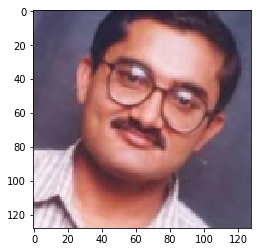

In [118]:
plt.imshow(ciao)

In [119]:
x*360/(2*math.pi)

array([23.956348], dtype=float32)

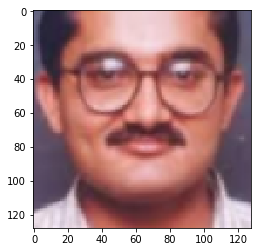

In [120]:
ciao = np.asarray(ciao)
ciao_ruotata = rotate(ciao,-(x*360/(2*math.pi)),128)
plt.imshow(ciao_ruotata)